
### Importing Required libraries



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils

import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


### Import Data

In [2]:
!wget -O brain_tumor_dataset.zip https://figshare.com/ndownloader/articles/1512427/versions/5

--2022-10-15 10:11:24--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 46.137.131.113, 52.212.179.229, 2a05:d018:1f4:d000:d179:cc76:f57d:d78e, ...
Connecting to figshare.com (figshare.com)|46.137.131.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘brain_tumor_dataset.zip’

brain_tumor_dataset 100%[===================>] 838.76M  83.7MB/s    in 9.2s    

2022-10-15 10:11:34 (91.6 MB/s) - ‘brain_tumor_dataset.zip’ saved [879501695/879501695]



In [3]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
 !unzip brain_tumor_dataset.zip

Archive:  brain_tumor_dataset.zip
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [5]:
!mkdir brain_tumor_dataset

!unzip brainTumorDataPublic_1-766.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_767-1532.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_1533-2298.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_2299-3064.zip -d brain_tumor_dataset

Archive:  brainTumorDataPublic_1-766.zip
  inflating: brain_tumor_dataset/1.mat  
  inflating: brain_tumor_dataset/10.mat  
  inflating: brain_tumor_dataset/100.mat  
  inflating: brain_tumor_dataset/101.mat  
  inflating: brain_tumor_dataset/102.mat  
  inflating: brain_tumor_dataset/103.mat  
  inflating: brain_tumor_dataset/104.mat  
  inflating: brain_tumor_dataset/105.mat  
  inflating: brain_tumor_dataset/106.mat  
  inflating: brain_tumor_dataset/107.mat  
  inflating: brain_tumor_dataset/108.mat  
  inflating: brain_tumor_dataset/109.mat  
  inflating: brain_tumor_dataset/11.mat  
  inflating: brain_tumor_dataset/110.mat  
  inflating: brain_tumor_dataset/111.mat  
  inflating: brain_tumor_dataset/112.mat  
  inflating: brain_tumor_dataset/113.mat  
  inflating: brain_tumor_dataset/114.mat  
  inflating: brain_tumor_dataset/115.mat  
  inflating: brain_tumor_dataset/116.mat  
  inflating: brain_tumor_dataset/117.mat  
  inflating: brain_tumor_dataset/118.mat  
  inflating: brai

In [6]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Preprocessing

In [7]:
from pymatreader import read_mat

def read_mat_file(single_file):
    return read_mat(os.path.join(single_file))

In [8]:
import pathlib
dataset_folder = 'brain_tumor_dataset'
DatasetFiles = list(pathlib.Path(os.path.join(dataset_folder)).glob("*.*"))
classes = ["meningioma", "glioma","pituitary"]

In [9]:
def collect_features_labels(DatasetFiles):
    images = []
    images_meng = []
    images_glio = []
    images_pitu = []
    labels = []
    for single_file in DatasetFiles:
      mat_obj = read_mat_file(single_file)
      img = mat_obj['cjdata']['image']
      img = img/255
      img = np.float32(img)
      img = cv2.resize(img, (224, 224))
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = img - np.mean(img)
      img = img/np.std(img)
      lab = int(mat_obj['cjdata']['label'])
      if(lab == 1):
        images_meng.append(img)
      elif(lab==2):
        images_glio.append(img)
      else:
        images_pitu.append(img)
      
      images.append(img)
      labels.append(lab)
    images = np.asarray(images)
    labels = np.asarray(labels)
    ###########
    images_meng = np.asarray(images_meng)
    images_glio = np.asarray(images_glio)
    images_pitu = np.asarray(images_pitu)
    ###########
    return images, labels, images_meng,images_glio,images_pitu

In [10]:
images, labels, images_meng,images_glio,images_pitu = collect_features_labels(DatasetFiles)

In [11]:
s_men =0
s_p =0
s_g = 0

for i in range(len(labels)):
  if(labels[i]==1):
    s_men +=1
  elif(labels[i]==2):
    s_p +=1
  else :
    s_g +=1

s= s_men + s_p+s_g
print(s)

print(s_men)
print(s_p)
print(s_g)



3064
708
1426
930


In [68]:
plt.pie(labels.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'Glioma Tumor'],radius=3)
plt.show()

AttributeError: ignored

In [ ]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);


[1 2 3]


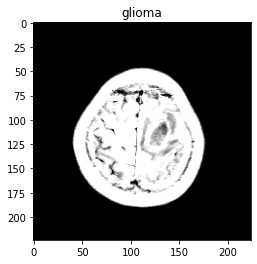

In [13]:
print(np.unique(labels))
i = 1
plt.imshow(images[i])
plt.title(classes[labels[i]-1])
plt.show()

In [14]:
def DataAugmentation_Object():
    return tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,zoom_range=0.01,horizontal_flip=True,vertical_flip=True,rescale=None)
def augmentated_images(images,labels):
   images_after_aug = []
   labels_after_aug = []
   augmentation_object = DataAugmentation_Object()

   for j in range(len(images_meng)):
     if(j<800):
      for i in range(1):
          img = augmentation_object.flow(np.reshape(images_meng[j], (1, 224, 224, 3))).next()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(1)
  
   for j in range(len(images_glio)):
     if(j<100):
      for i in range(1):
          img = augmentation_object.flow(np.reshape(images_glio[j], (1, 224, 224, 3))).next()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(2)

   for j in range(len(images_pitu)):
     if(j<500):
      for i in range(1):
          img = augmentation_object.flow(np.reshape(images_pitu[j], (1, 224, 224, 3))).next()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(3)           

   labels_after_aug = np.asarray(labels_after_aug)
   images_after_aug = np.asarray(images_after_aug)
   return images_after_aug, labels_after_aug

In [15]:
images_after_aug, labels_after_aug = augmentated_images(images, labels)

In [16]:
print(images_after_aug.shape)
print(images.shape)

(1308, 224, 224, 3)
(3064, 224, 224, 3)


In [17]:
images_all = np.concatenate((images,images_after_aug ), axis=0)
images_all.shape

del images,images_after_aug

labels_all = np.concatenate((labels,labels_after_aug ), axis=0)
labels_all.shape

del labels, labels_after_aug

In [18]:
images = images_all
labels = labels_all

print(labels)

[1 2 3 ... 3 3 3]


In [19]:
np.unique(labels)

array([1, 2, 3])

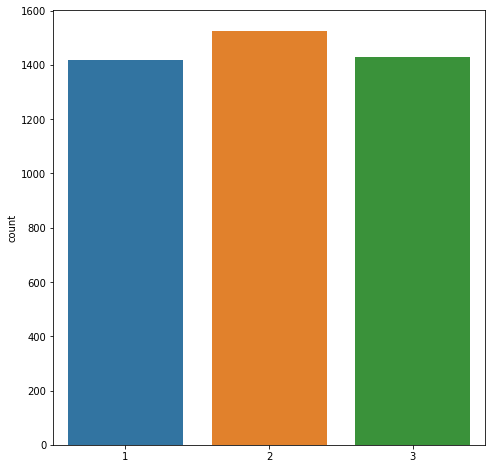

In [20]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);

In [21]:
def to_categorical_label(labels):
    labels = labels - 1
    labels = tf.keras.utils.to_categorical(labels, num_classes = 3)
    return labels

In [22]:
labels = to_categorical_label(labels)

### Split dataset int train and test sets

In [23]:
#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
X_train,X_rem,y_train,y_rem = train_test_split(images,labels, train_size=0.8,random_state=101)

X_val,X_test,y_val,y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=101)

'''
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(images, target = labels, 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)'''


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3497, 224, 224, 3)
(437, 224, 224, 3)
(438, 224, 224, 3)


#### Config_train

In [24]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
session.as_default()


In [25]:

BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 5e-3
MAX_LR = 1e-3
Lr = 1e-3

In [26]:

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x = x_set # camera vector
        self.y = y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return batch_x, batch_y

In [27]:
train_gen = DataGenerator(X_train, y_train, BATCH_SIZE)
val_gen   = DataGenerator(X_val,   y_val,   BATCH_SIZE)
test_gen  = DataGenerator(X_test,  y_test,  BATCH_SIZE)

### Transfer Learning


In [28]:
image_size = 224

In [29]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model= tf.keras.layers.Dropout(0.8)(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.8)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

16705208/16705208 [==============================] - 0s 0us/step


In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, mode='auto'),
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_accuracy', mode = 'max', restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("/content/bestmodel.hdf5", monitor='val_accuracy', save_best_only=True,mode='max', save_freq='epoch')]
                             


In [31]:
import tensorflow.keras.backend as KB

with session.as_default():
  KB.clear_session()
  model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
  
history_all = {}
with session.as_default():
  history = model.fit(train_gen, validation_data=val_gen, epochs =30,verbose=1, batch_size=BATCH_SIZE,callbacks=callbacks)
  


Epoch 1/30
110/110 [==============================] - 55s 339ms/step - loss: 0.4046 - accuracy: 0.8413 - val_loss: 1.7102 - val_accuracy: 0.3364 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - 34s 313ms/step - loss: 0.1501 - accuracy: 0.9445 - val_loss: 1.7578 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - 35s 316ms/step - loss: 0.0974 - accuracy: 0.9665 - val_loss: 0.7228 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 4/30
110/110 [==============================] - 34s 311ms/step - loss: 0.0424 - accuracy: 0.9840 - val_loss: 2.0856 - val_accuracy: 0.5309 - lr: 0.0010
Epoch 5/30
110/110 [==============================] - 34s 313ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 2.1509 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 6/30
110/110 [==============================] - 35s 322ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.7595 - val_accuracy: 0.7643 - lr: 3.0000e-04
Epoch 7/30
110/110 [============================

In [34]:
model.load_weights("/content/bestmodel.hdf5")

In [35]:
#model.save("brain_model.h5")

### Evaluating the model

In [36]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

14/14 [==============================] - 3s 99ms/step


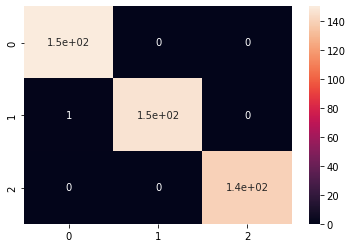

In [37]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    y_test_new,
    pred,
), annot=True)

In [38]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.99      1.00       148
           2       1.00      1.00      1.00       140

    accuracy                           1.00       438
   macro avg       1.00      1.00      1.00       438
weighted avg       1.00      1.00      1.00       438



In [44]:
from sklearn.metrics import f1_score
f1_score(y_test_new, pred, average='macro')

0.9977626367851041

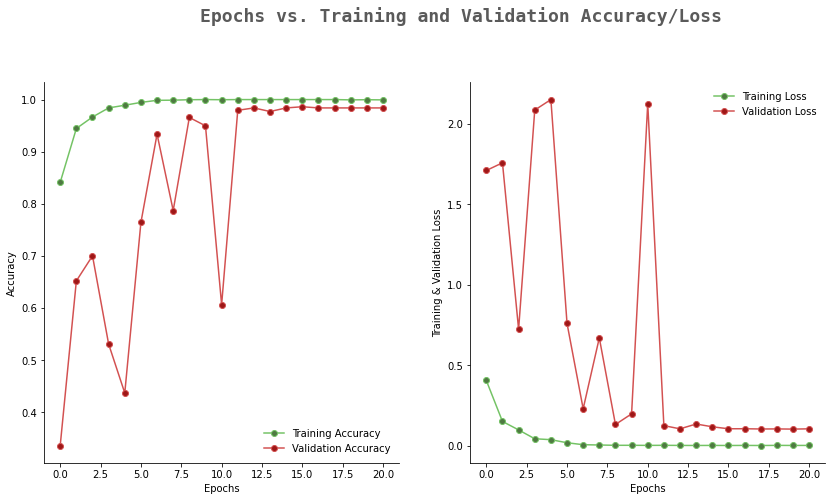

In [40]:
from warnings import filterwarnings

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

filterwarnings('ignore')

epochs = [i for i in range(len(history.history['loss']))]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()


ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()

ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()


1/1 [==============================] - 0s 33ms/step


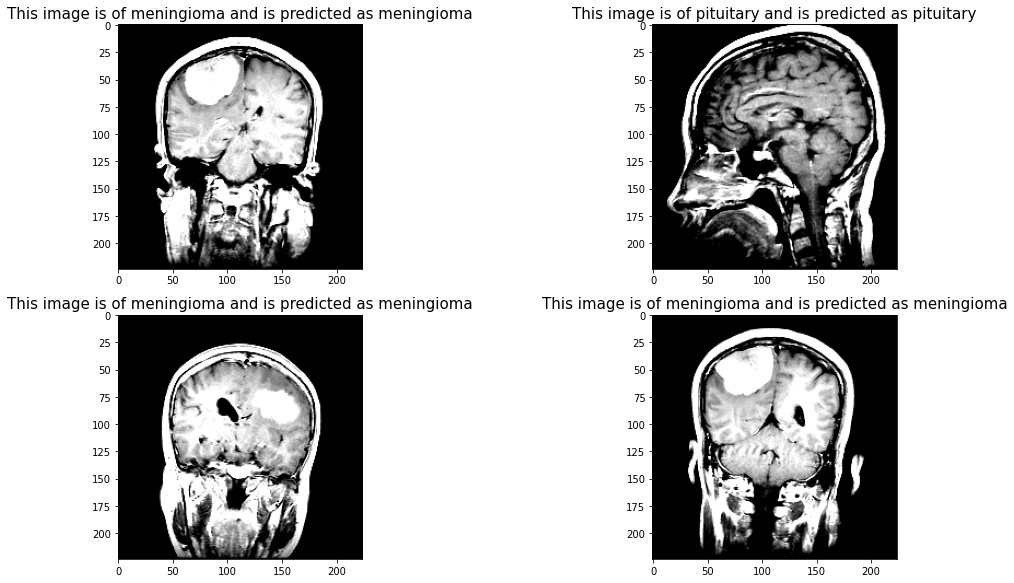

In [74]:
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=classes[np.argmax(model.predict(np.reshape(X_test[index],(-1,224,224,3))))]
    plt.title('This image is of {0} and is predicted as {1}'.format(classes[np.nonzero(y_test[index])[0][0]],pred_class),
              fontdict={'size':15})
    
    img = np.clip(X_test[index], 0, 1)
    plt.imshow(img) 

    plt.tight_layout()